# Tesseract Evaluation - zeilenbasiert

Um die Ergebnisse der Textextraktion mit Tesseract auf ihre Qualität hin besser untersuchen zu können, wird der Output zeilenweise verglichen. Diese kürzeren Strings könnten weniger "Folgefehler" enthalten und somit ein genaueres Ergebnis der Textextraktion liefern

#### 1. Textextraktion
    1.1 auf einem Beipielbild   
    1.2 auf dem gesamten Datensatz

#### 2. Evaluation
    2.1 Berechnung Char Accuracy und Word Accuracy
    2.2 Berechnung CER
    2.3 Berechnung WER

#### 3. weitere Analysen
    3.1 Erkennungsrate berechnen
    3.2 Char Accuracy und Word Accuraccy je Bildkategorie
    3.3 CER und WER je Bildkategorie
    3.4 Erkennungsrate je Bildkatgeorie

---

### 1. Textextraktion
---

#### 1.1 Textextraktion auf einem einzelnen Bild - zeilenweise Ausgabe

In [1]:
import pytesseract
from PIL import Image
import pandas as pd

# Bild laden
image = Image.open("../../data/images/insta_images/0002.jpg")

# OCR mit Datenstruktur
ocr_data = pytesseract.image_to_data(image, lang='deu', output_type=pytesseract.Output.DATAFRAME)

# Nur relevante Spalten und nur nicht-leere Zeilen
ocr_data = ocr_data[ocr_data.conf != -1]  # -1 = kein Text erkannt
ocr_data = ocr_data.dropna(subset=["text"])

# Gruppiere nach block_num, par_num, line_num
grouped = ocr_data.groupby(['block_num', 'par_num', 'line_num'])

# Zeilen zusammensetzen
lines = []
for (_, _, _), group in grouped:
    line_text = ' '.join(group['text'].tolist())
    lines.append(line_text)

# Ausgabe
for i, line in enumerate(lines, 1):
    print(f"Zeile {i}: {line}")

Zeile 1: #SOLIDARITÄT MIT ALLEN!
Zeile 2: BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?
Zeile 3: Dresden, Großer Garten, 8.8. um 16 Uhr
Zeile 4: CT
Zeile 5:  


#### ---->
**PROBLEM:** nicht alle TEXT-Zeilen werden von Tesseract erkannt -> der zeilenweise Vergleich mit dem originalen Text wäre also häufig fehlerhaft, da Zeilen "verschoben" wären. Zeile 1 im Ground Truth würde mit Zeile 1 des OCR Outputs gematcht werden. Diese Zeilen "gehören aber nicht zusammen". Obwohl Text durch Tesseract also richtig erkannt worden ist, wäre das Ergebniss des Vergleichs der Strings einzelner Zeilen fehlerhaft. Deshalb müssen die Zeilen, die am besten zueinander passen, einander zugeordnet werden.   
**IDEE:** Zeilen mittels Levenshtein Distance miteinander vergleichen -> die am besten passenden miteinander matchen

#### Textextraktion mit zeilenweisem Matching

In [2]:
import pytesseract
import os
import json
import pandas as pd

import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines, cer_for_matching, match_gt_to_ocr 

# === Konfiguration ===
IMG_NAME = "0002.jpg"              
DIR_PATH = "../../data/images/insta_images"
JSON = "../../data/data_annotated.json"
CER_THRESHOLD = 0.4


with open(JSON, "r", encoding="utf-8") as f:
    all_data = json.load(f)

eintrag = next((item for item in all_data if item.get("file_name") == IMG_NAME), None)
if eintrag is None:
    print(f"Kein Groundtruth-Eintrag für {IMG_NAME}")
else:
    gt_lines = eintrag["lines"]
    img_path = os.path.join(DIR_PATH, IMG_NAME)

    if not os.path.exists(img_path):
        print(f"Bild nicht gefunden: {img_path}")
    else:
        ocr_lines = extract_ocr_lines(img_path)
        matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

        ergebnisse = []
        for gt_idx, ocr_idx in matches:
            gt_line = gt_lines[gt_idx]
            if ocr_idx is not None:
                ocr_line = ocr_lines[ocr_idx]
            else:
                ocr_line = "[Nicht erkannt]"

            ergebnisse.append({
                "GT-Zeile (Index)": gt_idx,
                "GT-Zeile": gt_line,
                "OCR-Zeile (Index)": ocr_idx,
                "OCR-Zeile": ocr_line,
            })

        df = pd.DataFrame(ergebnisse)
        display(df)


,GT-Zeile (Index),GT-Zeile,OCR-Zeile (Index),OCR-Zeile
0,0,SCHLIESST EUCH AN!,NaN,[Nicht erkannt]
1,1,ET Video & Content,NaN,[Nicht erkannt]
2,2,nichtohneuns_Dresden,NaN,[Nicht erkannt]
3,3,KUNDGEBUNG,NaN,[Nicht erkannt]
4,4,#SOLIDARITÄT MIT ALLEN!,0.0,#SOLIDARITÄT MIT ALLEN!
5,5,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?,1.0,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?
6,6,"Dresden, Großer Garten, 8.8. um 16 Uhr",2.0,"Dresden, Großer Garten, 8.8. um 16 Uhr"


In [3]:
import Levenshtein

def character_accuracy(ocr_text, ground_truth):
    ocr_text = ocr_text.strip()
    ground_truth = ground_truth.strip()
    max_len = len(ground_truth)
    
    if ocr_text == "[Nicht erkannt]":
        return 0.0
    
    if max_len == 0:
        return 1.0 if not ocr_text else 0.0

    distance = Levenshtein.distance(ocr_text, ground_truth)
    return 1 - (distance / max_len)


df["char_accuracy"] = df.apply(
    lambda row: character_accuracy(row["OCR-Zeile"], row["GT-Zeile"]),
    axis=1
)


In [4]:
df.head(7)

,GT-Zeile (Index),GT-Zeile,OCR-Zeile (Index),OCR-Zeile,char_accuracy
0,0,SCHLIESST EUCH AN!,NaN,[Nicht erkannt],0.0
1,1,ET Video & Content,NaN,[Nicht erkannt],0.0
2,2,nichtohneuns_Dresden,NaN,[Nicht erkannt],0.0
3,3,KUNDGEBUNG,NaN,[Nicht erkannt],0.0
4,4,#SOLIDARITÄT MIT ALLEN!,0.0,#SOLIDARITÄT MIT ALLEN!,1.0
5,5,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?,1.0,BERICHTE: WIE WAR DIE BERLIN-DEMO WIRKLICH?,1.0
6,6,"Dresden, Großer Garten, 8.8. um 16 Uhr",2.0,"Dresden, Großer Garten, 8.8. um 16 Uhr",1.0


In [5]:
mean_acc = df["char_accuracy"].mean()
print((mean_acc)* 100)

42.857142857142854


#### 1.2 Textextraktion auf gesamten Datensatz - zeilenweise Ausgabe / Zeilen gematcht

In [6]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines, cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD 


# === Konfiguration ===
IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"




with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines(img_path)
    matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = ocr_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None
    })

df_results = pd.DataFrame(ergebnisse)
display(df_results)


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000
...,...,...,...,...,...,...,...,...
195,0238.jpg,13,16,4,0.775403,0.994872,0.231068,0.000000
196,0239.jpg,11,1,0,1.000000,1.000000,0.000000,0.000000
197,0240.jpg,10,10,10,0.014345,0.116667,0.995833,0.816667
198,0241.jpg,17,38,1,0.942455,0.952941,0.057423,0.047059


---
### 2. Evaluation
---

#### 2.1 Berechnung Character Accuracy und Word Accuracy


In [7]:
char_acc_mean_all = df_results["mean_char_acc"].mean()
print(f"Durchschnittliche Character Accuracy : {char_acc_mean_all * 100:.2f}%")

Durchschnittliche Character Accuracy : 39.02%


In [8]:
word_acc_mean_all = df_results["mean_word_acc"].mean()
print(f"Durchschnittliche Word Accuracy : {word_acc_mean_all * 100:.2f}%")

Durchschnittliche Word Accuracy : 29.57%


##### ---> die Character Accuracy hat sich verschlechtert  von 46.41% (siehe notebook- 01) auf 39.02%
##### ---> die Word Accuracy hat sich signifikant verbessert von 11.06% auf 29.57%


#### 2.2 Berechnung CER (Character Error Rate)

In [9]:
cer_mean_all = df_results["mean_cer"].mean()
print(f"Durchschnittlicher CER : {cer_mean_all * 100:.2f}%")

Durchschnittlicher CER : 61.65%


#### 2.2 Berechnung WER (Word Error Rate)

In [10]:
wer_mean_all = df_results["mean_wer"].mean()
print(f"Durchschnittlicher WER : {wer_mean_all * 100:.2f}%")

Durchschnittlicher WER : 71.68%


In [11]:
df_results.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm3.csv", index=False)

---
##### PRÜFUNG:  Berechnung auf "normalisiertem" OCR-Text - verändert das die Ergebnisse?  
Zeilenweise wird der Text, sofern vorhanden, von unnötigen Leerzeichen und Tabs befreit. 

In [17]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines, cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer 


# === Konfiguration ===
IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"
CER_THRESHOLD = 0.4

# === Hilfsfunktion ===
def normalize_text(ocr_tesseract):
    return ' '.join(str(ocr_tesseract).split()) if pd.notna(ocr_tesseract) else ''


with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines(img_path)
    normalized_lines = [normalize_text(line) for line in ocr_lines]
    matches = match_gt_to_ocr(gt_lines, normalized_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = normalized_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None
    })

df_results_normalized = pd.DataFrame(ergebnisse)
display(df_results_normalized)


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000
...,...,...,...,...,...,...,...,...
195,0238.jpg,13,16,4,0.775403,0.994872,0.231068,0.000000
196,0239.jpg,11,1,0,1.000000,1.000000,0.000000,0.000000
197,0240.jpg,10,10,10,0.014345,0.116667,0.995833,0.816667
198,0241.jpg,17,38,1,0.942455,0.952941,0.057423,0.047059


In [19]:
char_acc_mean_all = df_results_normalized["mean_char_acc"].mean()
print(f"Durchschnittliche Character Accuracy : {char_acc_mean_all * 100:.2f}%")

Durchschnittliche Character Accuracy : 39.02%


In [20]:
word_acc_mean_all = df_results_normalized["mean_word_acc"].mean()
print(f"Durchschnittliche Word Accuracy : {word_acc_mean_all * 100:.2f}%")

Durchschnittliche Word Accuracy : 29.57%


In [21]:
cer_mean_all = df_results_normalized["mean_cer"].mean()
print(f"Durchschnittlicher CER : {cer_mean_all * 100:.2f}%")

Durchschnittlicher CER : 61.65%


In [22]:
wer_mean_all = df_results_normalized["mean_wer"].mean()
print(f"Durchschnittlicher WER : {wer_mean_all * 100:.2f}%")

Durchschnittlicher WER : 71.68%


----> die Werte des normalisierten Textes unterscheiden sich nicht von dem nicht nachträglich bearbeiteten Text.   
Der Text war schon zuvor frei von unnötigen Leerzeichen oder Tabs. Die Ergebnisse/Werte des normailisierten Textes werden deshalb nicht eigens gespeichert.


---
### 3. weitere Analysen
---

#### joinen der beiden Datensätze  (CSV mit ground truth und generierte Evaluationsdatei) 


In [12]:
import pandas as pd

df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")
df = pd.read_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm3.csv")


In [13]:
# Nur die Spalten "name" und "category" 
df_pics_little = df_pics[["file_name", "category"]]

# Merge 
merged_df = df.merge(df_pics_little, on="file_name", how="left")


merged_df.head()


,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,category
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667,noisy
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571,noisy
2,0003.jpg,11,16,5,0.589539,0.621212,0.414100,0.272727,noisy
3,0004.jpg,11,5,1,0.943574,1.000000,0.059441,0.000000,noisy
4,0006.jpg,8,4,2,0.790000,0.791667,0.206250,0.125000,noisy


In [15]:
matched_lines_mean = merged_df["matched_lines"].mean()
print(matched_lines_mean)


4.27


In [16]:
gt_lines_mean = merged_df["gt_lines"].mean()
print(gt_lines_mean)

10.22


In [17]:
matched_lines_mean_per_cat = merged_df.groupby("category")["matched_lines"].mean() 
print(matched_lines_mean_per_cat)

category
fancy     3.981481
noisy     2.933333
photo     3.800000
simple    5.230769
skewed    4.354839
Name: matched_lines, dtype: float64


#### 3.1 Erkennungsrate berrechnen
Wie viele Zeilen des ground truth wurden je Bild erkannt?

In [18]:
merged_df["recognition_rate"] = merged_df["matched_lines"] / merged_df["gt_lines"]


In [19]:
merged_df.head(2)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,category,recognition_rate
0,0001.jpg,6,8,4,0.351852,0.416667,0.656863,0.666667,noisy,0.666667
1,0002.jpg,7,5,3,0.571429,0.571429,0.428571,0.428571,noisy,0.428571


In [20]:
merged_df.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm3.csv", index=False)

In [21]:
# Durchschnitt berechnen
mean_cer = merged_df["mean_cer"].mean()
mean_wer = merged_df["mean_wer"].mean()
mean_ER = merged_df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")


Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.420
CER: 0.616
WER: 0.717


#### 3.2 Char Accuracy und Word Accuracy je Bildkategorie

In [22]:
CHAR_ACC_by_category = merged_df.groupby("category")["mean_char_acc"].mean() * 100
CHAR_ACC_by_category = CHAR_ACC_by_category.round(2)
CHAR_ACC_by_category = CHAR_ACC_by_category.sort_values(ascending=False)

print(CHAR_ACC_by_category)

category
simple    52.42
skewed    36.74
fancy     32.64
noisy     30.38
photo     29.15
Name: mean_char_acc, dtype: float64


In [23]:
WORD_ACC_by_category = merged_df.groupby("category")["mean_word_acc"].mean() * 100
WORD_ACC_by_category = WORD_ACC_by_category.round(2)
WORD_ACC_by_category = WORD_ACC_by_category.sort_values(ascending=False)

print(WORD_ACC_by_category)

category
simple    43.89
skewed    28.03
fancy     21.61
noisy     21.13
photo     19.62
Name: mean_word_acc, dtype: float64


#### 3.3 CER und WER je Bildkategorie

In [24]:
CER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
CER_by_category = CER_by_category.round(2)
CER_by_category = CER_by_category.sort_values(ascending=True)

print(CER_by_category)

category
simple    48.24
skewed    63.95
fancy     68.07
noisy     70.08
photo     71.67
Name: mean_cer, dtype: float64


In [25]:
WER_by_category = merged_df.groupby("category")["mean_wer"].mean() * 100
WER_by_category = WER_by_category.round(2)
WER_by_category = WER_by_category.sort_values(ascending=True)
print(WER_by_category)

category
simple    56.46
skewed    74.39
noisy     79.87
photo     80.45
fancy     80.63
Name: mean_wer, dtype: float64


### 3.3 Erkennungsrate je Bildkategorie

In [28]:
Erkennungsrate_by_category = merged_df.groupby("category")["recognition_rate"].mean() * 100
Erkennungsrate_by_category = Erkennungsrate_by_category.round(2)
Erkennungsrate_by_category = Erkennungsrate_by_category.sort_values(ascending=False)

print(Erkennungsrate_by_category)

category
simple    55.23
skewed    39.76
fancy     35.76
noisy     33.26
photo     32.47
Name: recognition_rate, dtype: float64


---

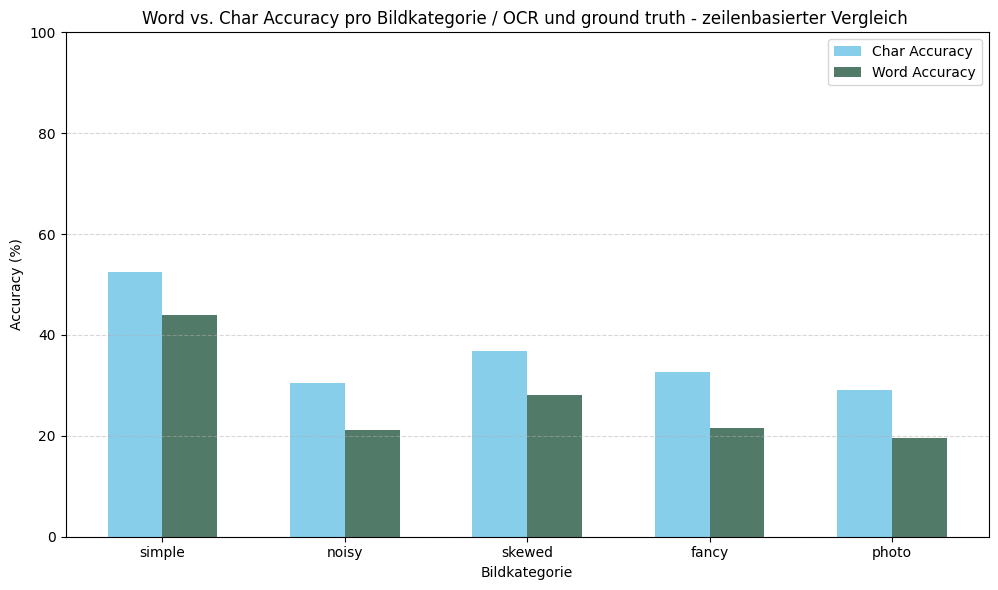

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
word_accuracy = [43.89, 21.13, 28.03, 21.61, 19.62]
char_accuracy = [52.42, 30.38, 36.74, 32.64, 29.15]


df = pd.DataFrame({
    'category': categories,
    'word_accuracy': word_accuracy,
    'char_accuracy': char_accuracy
})

# Balkendiagramm
x = range(len(categories))
bar_width = 0.30

plt.figure(figsize=(10, 6))
plt.bar(x, df['char_accuracy'], width=bar_width, label='Char Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], df['word_accuracy'], width=bar_width, label='Word Accuracy', color='#527a68')

plt.xlabel('Bildkategorie')
plt.ylabel('Accuracy (%)')
plt.title('Word vs. Char Accuracy pro Bildkategorie / OCR und ground truth - zeilenbasierter Vergleich ')
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.show()

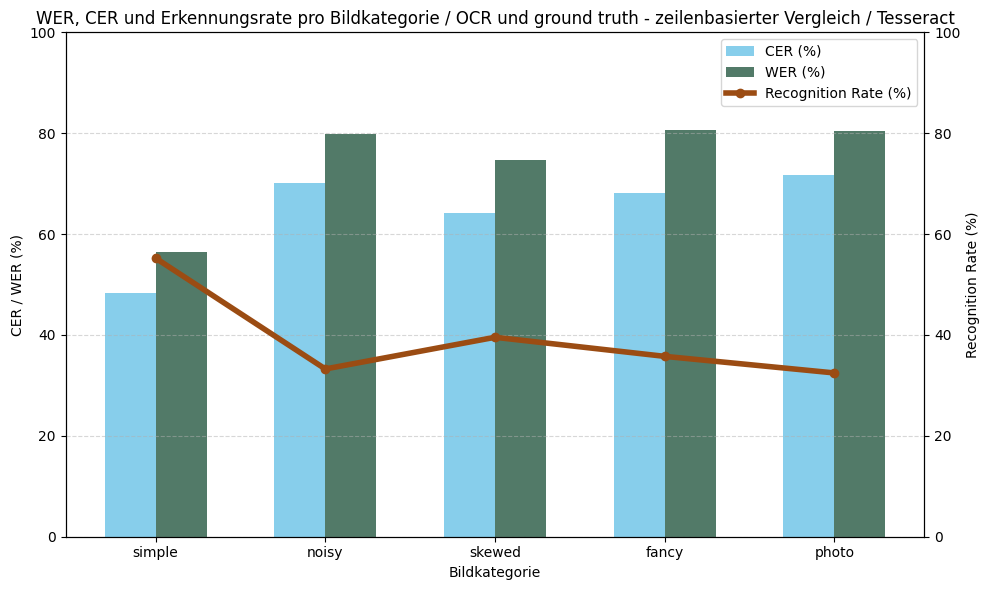

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Kategorien und Werte
categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
wer = [56.46, 79.87, 74.61, 80.63, 80.45]          
cer = [48.24, 70.08, 64.17, 68.08, 71.74]         
recognition_rate = [55.23, 33.26, 39.54, 35.76, 32.47]  


# DataFrame
df = pd.DataFrame({
    'category': categories,
    'WER': wer,
    'CER': cer,
    'RecognitionRate': recognition_rate
})

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(categories))
bar_width = 0.30

# Balken für WER und CER
ax1.bar(x, df['CER'], width=bar_width, label='CER (%)', color='skyblue')
ax1.bar([i + bar_width for i in x], df['WER'], width=bar_width, label='WER (%)', color='#527a68')

ax1.set_ylabel('CER / WER (%)')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Bildkategorie')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(categories)

# Zweite Y-Achse für Erkennungsrate
ax2 = ax1.twinx()
ax2.plot([i + bar_width / 2 for i in x], df['RecognitionRate'], label='Recognition Rate (%)', color='#9B4C13', marker='o', linewidth=4)
ax2.set_ylabel('Recognition Rate (%)')
ax2.set_ylim(0, 100)

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('WER, CER und Erkennungsrate pro Bildkategorie / OCR und ground truth - zeilenbasierter Vergleich / Tesseract')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


---
#### Zusatz

In [31]:
# images bei denen kein Text extrahiert wurde
merged_df[merged_df['ocr_lines'] == 0].groupby('category').size()

category
fancy    1
dtype: int64

In [32]:
# images bei denen keine Zeile des OCR textes mit dem einer Zeile des ground truth matcht
merged_df[merged_df['matched_lines'] == 0].groupby('category').size()

category
fancy     9
noisy     8
photo     7
simple    8
skewed    7
dtype: int64

In [33]:
# images die eine guten WER haben 
merged_df[merged_df['mean_wer'] < 0.11].groupby('category').size()

category
fancy     1
simple    6
dtype: int64

In [34]:
merged_df.loc[merged_df['mean_wer'] < 0.11, 'file_name']

52     0064.jpg
94     0123.jpg
103    0134.jpg
114    0148.jpg
123    0158.jpg
136    0173.jpg
191    0234.jpg
Name: file_name, dtype: object

In [35]:
# images die eine guten CER haben 
merged_df[merged_df['mean_cer'] < 0.05].groupby('category').size()

category
fancy     1
simple    8
dtype: int64

In [36]:
merged_df.loc[merged_df['mean_cer'] < 0.05, 'file_name']

52      0064.jpg
94      0123.jpg
103     0134.jpg
105     0136.jpg
109    0142.jpeg
114     0148.jpg
123     0158.jpg
191     0234.jpg
197     0240.jpg
Name: file_name, dtype: object

In [43]:
# images die eine gute recognition rate haben
print(merged_df.loc[merged_df["recognition_rate"] > 0.99, "file_name"])

7       0010.jpg
34      0041.jpg
53      0066.jpg
94      0123.jpg
103     0134.jpg
105     0136.jpg
109    0142.jpeg
114     0148.jpg
123     0158.jpg
133    0170.jpeg
136     0173.jpg
191     0234.jpg
197     0240.jpg
Name: file_name, dtype: object


In [42]:
merged_df[merged_df["recognition_rate"] > 0.99].groupby('category').size()

category
fancy      2
noisy      1
simple    10
dtype: int64

In [46]:
# images die eine schlechte recognition rate haben
print(merged_df.loc[merged_df["recognition_rate"] < 0.05, "file_name"])

5       0007.jpg
6       0009.jpg
8       0011.jpg
11      0014.jpg
21      0025.jpg
22      0026.jpg
23      0027.jpg
28      0032.jpg
30      0036.jpg
31     0037.jpeg
45      0055.jpg
59      0075.jpg
60      0078.png
64      0086.jpg
67      0091.jpg
70      0095.jpg
71      0096.jpg
74      0099.jpg
75      0100.jpg
78      0104.jpg
81      0110.jpg
86      0115.jpg
110     0143.jpg
111     0145.jpg
115     0149.jpg
116     0151.jpg
121    0156.jpeg
135     0172.jpg
144     0183.jpg
145     0185.jpg
148     0190.jpg
150     0193.jpg
152     0195.jpg
164     0207.jpg
168     0211.jpg
171     0214.jpg
183     0226.jpg
184     0227.jpg
186     0229.jpg
196     0239.jpg
Name: file_name, dtype: object


In [47]:
merged_df[merged_df["recognition_rate"] < 0.05].groupby('category').size()

category
fancy     10
noisy      8
photo      7
simple     8
skewed     7
dtype: int64

In [48]:
merged_df[merged_df["recognition_rate"] < 0.2].groupby('category').size()

category
fancy     16
noisy     11
photo      7
simple    13
skewed    11
dtype: int64

In [37]:
merged_df.to_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm3.csv", index=False)